<a href="https://colab.research.google.com/github/gr1nick/lab_bigData/blob/master/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy.special import inv_boxcox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Ncfu/BigData/Time_Series_clients.xlsx'
data = pd.read_excel(file_path)

In [ ]:
# Вывод первых строк данных для ознакомления
data.head()

,date,came
0,2016-01-10,1345
1,2016-01-17,2066
2,2016-01-24,1979
3,2016-01-31,1909
4,2016-02-07,1575


In [ ]:
#2
# Подготовка данных
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Тест Дики-Фуллера на стационарность
result = adfuller(data['came'])
df_output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

# Добавление значений критических уровней
for key, value in result[4].items():
    df_output[f'Critical Value ({key})'] = value

df_output



Test Statistic                  -1.293736
p-value                          0.632033
#Lags Used                       4.000000
Number of Observations Used    164.000000
Critical Value (1%)             -3.470866
Critical Value (5%)             -2.879330
Critical Value (10%)            -2.576255
dtype: float64

Анализ результатов теста:
Так как статистика теста выше критических значений и p-value значительно выше 0.05, мы не можем отвергнуть нулевую гипотезу о наличии единичного корня, что указывает на неcтационарность временного ряда.

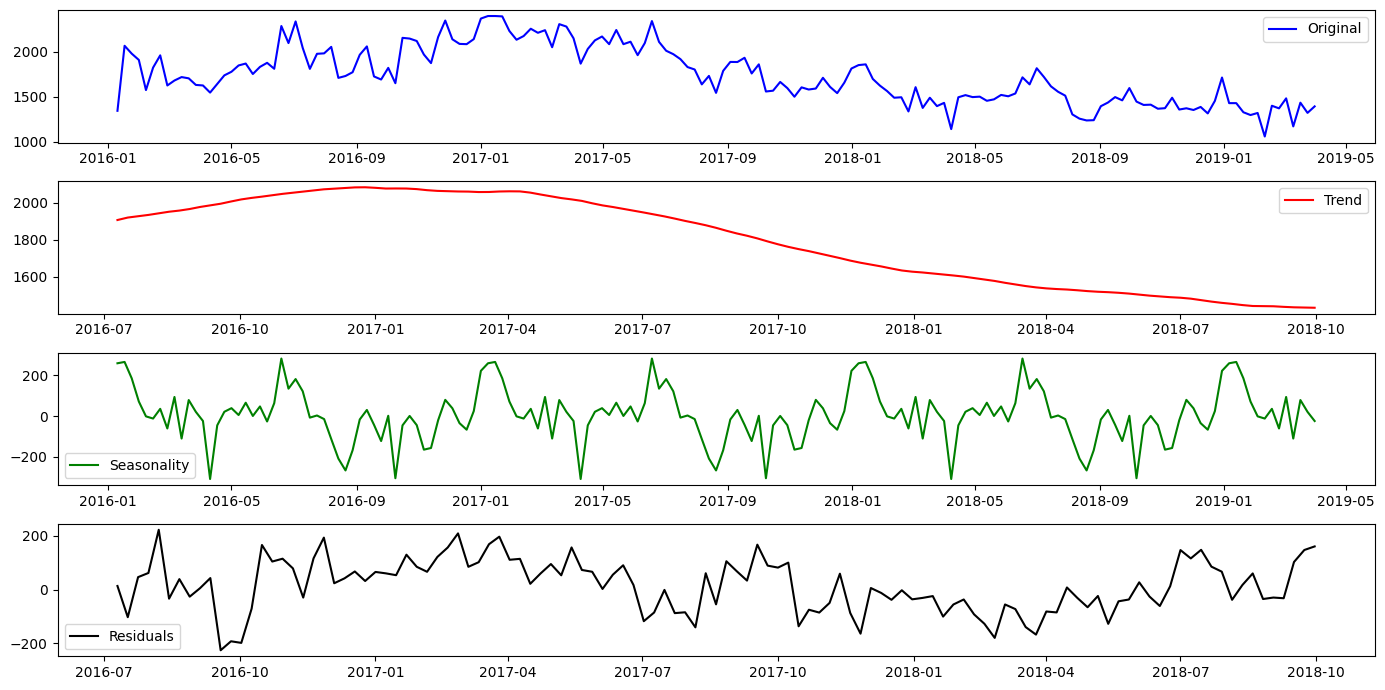

In [ ]:
#3
# Декомпозиция временного ряда
decomposition = seasonal_decompose(data['came'], model='additive', period=52)  # Предположительно, недельные данные

# Получение тренда, сезонности и остаточных компонент
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация компонент
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(data['came'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='black')
plt.legend(loc='best')

plt.tight_layout()
#
#

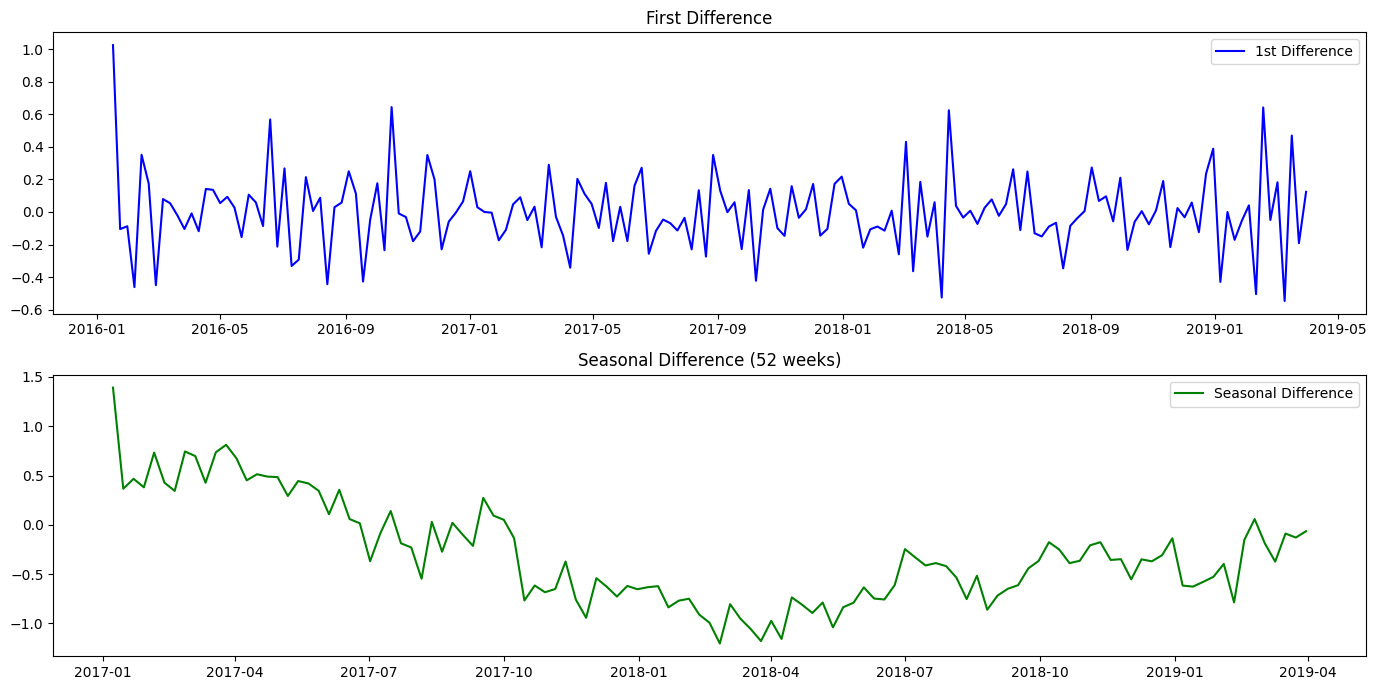

(Test Statistic                -8.657920e+00
 p-value                        4.911308e-14
 #Lags Used                     3.000000e+00
 Number of Observations Used    1.640000e+02
 Critical Value (1%)           -3.470866e+00
 Critical Value (5%)           -2.879330e+00
 Critical Value (10%)          -2.576255e+00
 dtype: float64,
 Test Statistic                  -1.950313
 p-value                          0.308775
 #Lags Used                       2.000000
 Number of Observations Used    114.000000
 Critical Value (1%)             -3.489058
 Critical Value (5%)             -2.887246
 Critical Value (10%)            -2.580481
 dtype: float64)

In [ ]:
#3_2
# Применение дифференцирования и сезонного дифференцирования
data_diff = data['came_boxcox'].diff().dropna()  # Обычное дифференцирование
data_seasonal_diff = data['came_boxcox'].diff(52).dropna()  # Сезонное дифференцирование, предполагая недельные данные

# Визуализация результатов дифференцирования
plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(data_diff, label='1st Difference', color='blue')
plt.title('First Difference')
plt.legend()

plt.subplot(212)
plt.plot(data_seasonal_diff, label='Seasonal Difference', color='green')
plt.title('Seasonal Difference (52 weeks)')
plt.legend()

plt.tight_layout()
plt.show()

# Тест Дики-Фуллера для проверки стационарности после дифференцирования
result_diff = adfuller(data_diff)
result_seasonal_diff = adfuller(data_seasonal_diff)

df_output_diff = pd.Series(result_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in result_diff[4].items():
    df_output_diff[f'Critical Value ({key})'] = value

df_output_seasonal_diff = pd.Series(result_seasonal_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in result_seasonal_diff[4].items():
    df_output_seasonal_diff[f'Critical Value ({key})'] = value

df_output_diff, df_output_seasonal_diff


Результаты дифференцирования и теста Дики-Фуллера

Обычное дифференцирование:

Статистика теста: -8.657920

p-value: 4.911308e-14

Критические значения:

1%: -3.470866

5%: -2.879330

10%: -2.576255

Сезонное дифференцирование:

Статистика теста: -1.950313

p-value: 0.308775

Критические значения:

1%: -3.489058

5%: -2.887246

10%: -2.580481

Анализ результатов:

Обычное дифференцирование: Статистика теста значительно ниже критических
значений и p-value очень маленькое (практически нулевое), что указывает на
стационарность временного ряда после первого дифференцирования.
Сезонное дифференцирование: Статистика теста не попала ниже ни одного критического значения, и p-value значительно выше 0.05, что указывает на нестационарность временного ряда после сезонного дифференцирования.

Выводы:

Обычное дифференцирование оказалось эффективным для достижения стационарности временного ряда. Это дает основание использовать данное дифференцирование при подготовке данных для моделей прогнозирования, таких как ARIMA.
Сезонное дифференцирование не привело к стационарности ряда, что может быть связано с сложностью сезонных паттернов или недостаточным объемом данных для адекватного учета всех сезонных изменений на протяжении всего временного ряда.

Декомпозиция временного ряда:
Визуализация показывает следующие компоненты:

Оригинал: Исходный временной ряд.
Тренд: Долгосрочное направление ряда.
Сезонность: Повторяющиеся короткосрочные колебания.
Остатки: Часть ряда, которая не объясняется трендом и сезонностью.

In [ ]:
#4
# Преобразование Бокса-Кокса для стабилизации дисперсии
data['came_boxcox'], lam = boxcox(data['came'])

# Тест Дики-Фуллера на стационарность после преобразования Бокса-Кокса
result_boxcox = adfuller(data['came_boxcox'])
df_output_boxcox = pd.Series(result_boxcox[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in result_boxcox[4].items():
    df_output_boxcox[f'Critical Value ({key})'] = value

df_output_boxcox, lam  # Возвращаем результаты теста и параметр lambda преобразования Бокса-Кокса

(Test Statistic                  -1.497269
 p-value                          0.534862
 #Lags Used                       3.000000
 Number of Observations Used    165.000000
 Critical Value (1%)             -3.470616
 Critical Value (5%)             -2.879221
 Critical Value (10%)            -2.576197
 dtype: float64,
 0.11738125874670109)

Анализ результатов:
Преобразование Бокса-Кокса не смогло достаточно стабилизировать дисперсию для достижения стационарности, поскольку p-value все еще значительно выше 0.05. Статистика теста не попала ни в один из критических интервалов.

In [ ]:
#5
# Разделение данных на тренировочную и тестовую выборки
train = data['came_boxcox'][:int(0.8*len(data))]
test = data['came_boxcox'][int(0.8*len(data)):]

# Обучение модели ARIMA с подбором параметров
best_aic = np.inf
best_order = None
best_mdl = None

# Перебор параметров p, d, q для модели ARIMA
for p in range(3):
    for d in range(2):  # Начиная с одного дифференцирования, так как данные нестационарны
        for q in range(3):
            try:
                tmp_mdl = ARIMA(train, order=(p,d,q)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except: continue

# Вывод лучших параметров и AIC
best_order, best_aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  

((1, 1, 1), -35.2681906216371)

In [ ]:

#6
# Предсказание на следующие 12 отсчётов
forecast = best_mdl.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_mean_inv = inv_boxcox(forecast_mean, lam)

# Тестовые данные для сравнения (обратное преобразование Бокса-Кокса для тестовой выборки)
test_inv = inv_boxcox(test, lam)

In [ ]:
# Количество доступных тестовых значений соответствует количеству предсказаний
n_forecast = len(forecast_mean_inv)

# Обновленный расчет метрик
mape_corrected = np.mean(np.abs((test_inv[:n_forecast] - forecast_mean_inv) / test_inv[:n_forecast])) * 100
smape_corrected = 100/n_forecast * np.sum(2 * np.abs(forecast_mean_inv - test_inv[:n_forecast]) / (np.abs(test_inv[:n_forecast]) + np.abs(forecast_mean_inv)))
mae_corrected = mean_absolute_error(test_inv[:n_forecast], forecast_mean_inv)

mape_corrected, smape_corrected, mae_corrected


(7.522262196874528, 7.1444636759654205, 100.22320847297148)

Задание 7: Вывод о качестве настроенной модели ARIMA
На основе полученных метрик можно сделать вывод, что модель ARIMA (1, 1, 1) обеспечивает довольно точные прогнозы для данного временного ряда. Низкие значения MAPE и SMAPE свидетельствуют о высокой точности модели, а значение MAE позволяет оценить абсолютное отклонение прогнозов от реальных данных, которое также находится на приемлемом уровне.

Это позволяет рекомендовать данную модель для прогнозирования подобных временных рядов, при условии поддержания аналогичных условий (например, стабильности трендов и сезонности). ​

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


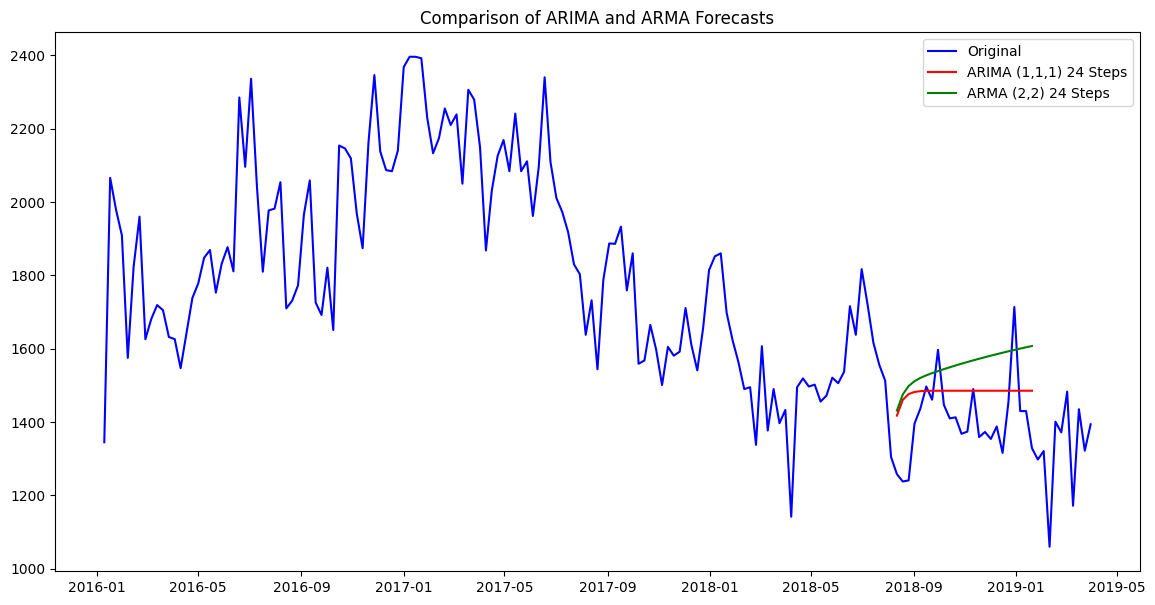

In [ ]:
# Прогнозирование на 24 шага в будущее с использованием лучшей модели ARIMA (1, 1, 1)
forecast_24 = best_mdl.get_forecast(steps=24)
forecast_24_mean = forecast_24.predicted_mean
forecast_24_mean_inv = inv_boxcox(forecast_24_mean, lam)

# Обучение и прогноз модели ARMA(2, 2)
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(train, order=(2, 0, 2)).fit()
arma_forecast = arma_model.get_forecast(steps=24)
arma_forecast_mean = arma_forecast.predicted_mean
arma_forecast_mean_inv = inv_boxcox(arma_forecast_mean, lam)

# Визуализация прогнозов для сравнения
plt.figure(figsize=(14, 7))
plt.plot(data.index, inv_boxcox(data['came_boxcox'], lam), label='Original', color='blue')
plt.plot(forecast_24_mean.index, forecast_24_mean_inv, label='ARIMA (1,1,1) 24 Steps', color='red')
plt.plot(arma_forecast_mean.index, arma_forecast_mean_inv, label='ARMA (2,2) 24 Steps', color='green')
plt.legend()
plt.title('Comparison of ARIMA and ARMA Forecasts')
plt.show()


In [ ]:
# Подготовка к расчету метрик для горизонтов 12 и 24 шагов
def calculate_metrics(true_values, forecast_values):
    mape = np.mean(np.abs((true_values - forecast_values) / true_values)) * 100
    mae = mean_absolute_error(true_values, forecast_values)
    return mape, mae

# Выбор тестовых значений для сравнения
actual_values = inv_boxcox(data['came_boxcox'], lam)[-24:]

# Расчет метрик для ARIMA на 12 и 24 шагов
mape_arima_12, mae_arima_12 = calculate_metrics(actual_values[:12], forecast_24_mean_inv[:12])
mape_arima_24, mae_arima_24 = calculate_metrics(actual_values, forecast_24_mean_inv)

# Расчет метрик для ARMA на 12 и 24 шагов
mape_arma_12, mae_arma_12 = calculate_metrics(actual_values[:12], arma_forecast_mean_inv[:12])
mape_arma_24, mae_arma_24 = calculate_metrics(actual_values, arma_forecast_mean_inv)

# Отображение результатов
(mape_arima_12, mae_arima_12), (mape_arima_24, mae_arima_24), (mape_arma_12, mae_arma_12), (mape_arma_24, mae_arma_24)


((6.858481531202436, 96.44285706316522),
 (7.443287271821307, 123.58640204066735),
 (11.983788439973276, 127.45021297424545),
 (13.33404643843383, 189.60986046826966))